# CNN with Data Augmentation

In [33]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
# from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.applications.resnet50 import ResNet50
from keras import backend as K

# Cargar datos

Se va a realizar la carga, preprocesamiento y visualización de los datos con el objetivo de prepararlos para su uso en modelos de redes neuronales. A continuación, se detalla el flujo de trabajo implementado:

1. **Definición de rutas y carga de imágenes**: Se especifican las rutas de acceso a las carpetas que contienen las imágenes de entrenamiento y prueba para lesiones benignas y malignas. Las imágenes se cargan en memoria, convirtiéndolas al formato RGB para garantizar la consistencia en la representación de color.

2. **Generación de etiquetas**: Para cada imagen, se asigna una etiqueta numérica que indica si la lesión es benigna (0) o maligna (1). Este proceso se realiza tanto para el conjunto de entrenamiento como de prueba.

3. **Combinación y barajado de datos**: Los datos de imágenes y etiquetas se combinan y luego se barajan aleatoriamente. Este paso es crucial para evitar cualquier sesgo durante el entrenamiento del modelo, asegurando que la distribución de los ejemplos sea uniforme.

4. **Visualización de los datos**: Finalmente, se visualiza una selección de imágenes del conjunto de entrenamiento. Cada imagen se muestra con su respectiva etiqueta, permitiendo una verificación visual rápida de la correcta carga y etiquetado de los datos.


In [34]:
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

In [35]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [36]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [37]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [38]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

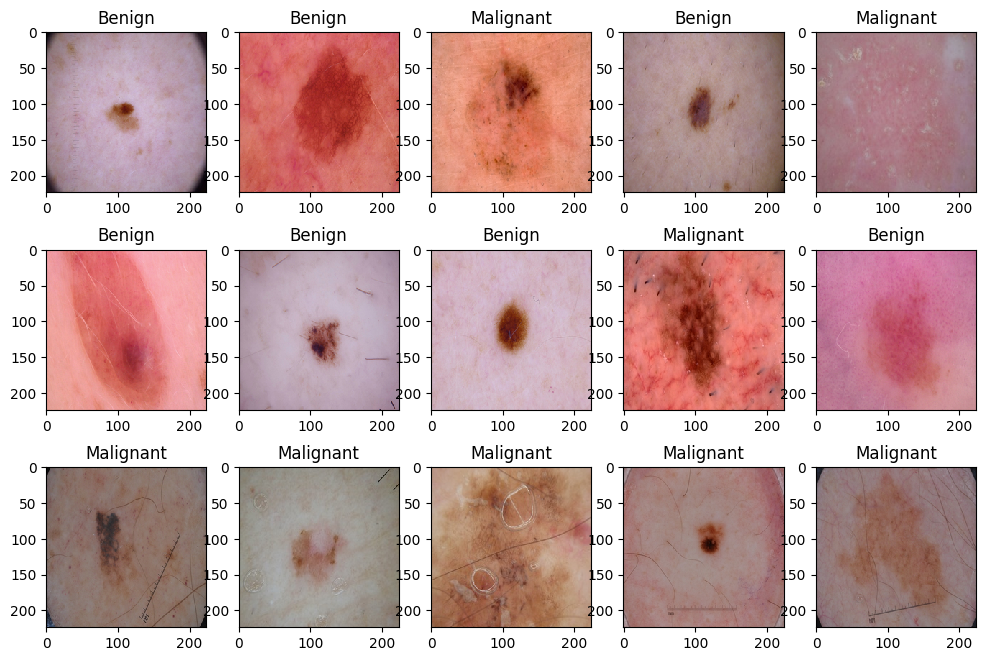

In [39]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Convertir etiquetas a categóricas

In [40]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalizar
Se realiza una normalización de los valores de píxeles de las imágenes tanto en el conjunto de entrenamiento como en el de prueba. Cada valor de píxel, originalmente en el rango de 0 a 255, se divide por 255 para obtener valores en el rango de 0 a 1. De esta manera se mejora la convergencia del modelo durante el entrenamiento, asegurando que todos los píxeles contribuyan equitativamente al aprendizaje y que los procesos computacionales se optimicen.

In [45]:
X_train = X_train/255.
X_test = X_test/255.

# Construir el modelo

### Arquitectura del Modelo

1. **Capa de entrada**: El modelo inicia con una capa convolucional que utiliza 32 filtros de tamaño 3x3 y función de activación ReLU. Esta capa es responsable de extraer las primeras características visuales básicas, como bordes y texturas, de las imágenes de entrada. La forma de entrada se define según el tamaño de las imágenes del conjunto de datos, que en este caso es de 224x224 píxeles y 3 canales de color (RGB).

2. **Capas de convolución y agrupamiento**: Se suceden varias capas convolucionales y de max pooling. Las capas convolucionales aumentan en número de filtros de 32 a 64 y luego a 128, permitiendo al modelo capturar características cada vez más complejas y abstractas. Las capas de max pooling (2x2) reducen progresivamente las dimensiones espaciales de los mapas de características, ayudando a hacer el modelo más eficiente y menos susceptible a las variaciones de posición de las características en las imágenes.

3. **Aplanamiento y capas densas**: Tras las capas convolucionales y de pooling, los mapas de características se aplanan en un vector largo, que se procesa a través de capas densas (fully connected). La primera capa densa tiene 128 neuronas, seguida de una capa de salida con 2 neuronas, cada una correspondiente a una clase del problema (benigno y maligno).

4. **Capa de salida**: La última capa utiliza la función de activación sigmoid, que es adecuada para clasificación binaria.


In [42]:
input_shape = (224, 224, 3)

# Creando el modelo de la red neuronal
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Una capa de max pooling adicional para manejar el aumento de tamaño de la imagen
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # Capa adicional para más complejidad
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))  # Aumentamos el tamaño aquí para ajustar al tamaño aumentado de las imágenes
model.add(layers.Dense(1, activation='sigmoid'))  # Dos clases de salida: benigno (0) y maligno (1)

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 64)       

In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Cambio en la función de pérdida para clasificación binaria
              metrics=['accuracy'])

In [32]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 25,
                    batch_size=64,
                    verbose=1,
                   )

Epoch 1/3




InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\belus\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\belus\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\belus\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\belus\AppData\Local\Temp\ipykernel_14924\1081981501.py", line 1, in <module>

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\belus\MasterBD\ADNE\skin-cancer-detection\CancerDetection\Lib\site-packages\keras\src\backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [20,28800], In[1]: [73728,128]
	 [[{{node sequential_1/dense_2/Relu}}]] [Op:__inference_train_function_2187]

In [42]:
# guardar modelo
if not os.path.exists('/content/drive/MyDrive/Datos no estructurados/Skin/models'):
    print('No existe la carpeta')
    os.mkdir('/content/drive/MyDrive/Datos no estructurados/Skin/models')

model.save('/content/drive/MyDrive/Datos no estructurados/Skin/models/cnn_scratch-25.h5')

In [43]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


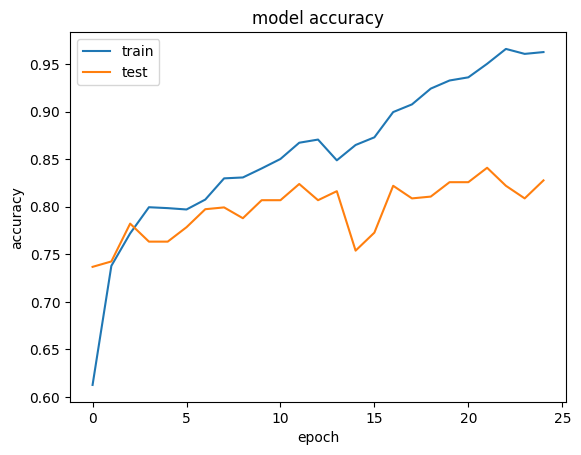

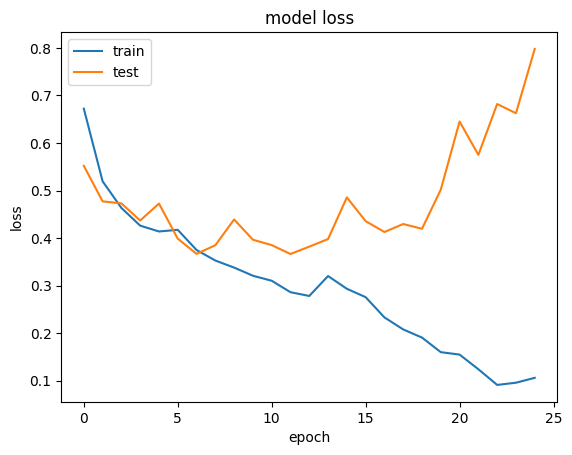

In [44]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Datos no estructurados/Skin/images/acc-25.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Datos no estructurados/Skin/images/loss-25.png')

In [44]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Datos no estructurados/Skin/images/acc-25.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Datos no estructurados/Skin/images/loss-25.png')

## Vamos a intentar reducir el sobreentrenamiento
Añadimos regularización L2 en la capa densa y una capa de Dropout para desactivar aleatoriamente un cierto porcentaje de neuronas durante el entrenamiento y evitar que el modelo se vuelva demasiado dependiente de ciertas características específicas.

In [14]:
input_shape = (224, 224, 3)  

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Cambio en la función de pérdida para clasificación binaria
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 40,
                    batch_size=64,
                    verbose=1,
                   )

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6150 - loss: 0.8936 - val_accuracy: 0.7538 - val_loss: 0.5953
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 976ms/step - accuracy: 0.7728 - loss: 0.5595 - val_accuracy: 0.7803 - val_loss: 0.5183
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 979ms/step - accuracy: 0.7750 - loss: 0.5024 - val_accuracy: 0.7481 - val_loss: 0.5378
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 961ms/step - accuracy: 0.7870 - loss: 0.4830 - val_accuracy: 0.7784 - val_loss: 0.4815
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 966ms/step - accuracy: 0.7766 - loss: 0.4909 - val_accuracy: 0.7519 - val_loss: 0.5320
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 962ms/step - accuracy: 0.8044 - loss: 0.4343 - val_accuracy: 0.7973 - val_loss: 0.4624
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 969ms/step - accuracy: 0.8073 - loss: 0.4207 - val_accuracy: 0.8030 - val_loss: 0.4553
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 964ms/step - accuracy: 0.8037 - loss: 0.4262 - val_accurac

In [18]:
# guardar modelo
if not os.path.exists('models'):
    print('No existe la carpeta')
    os.mkdir('models')

model.save('models/cnn_scratch-40.h5')

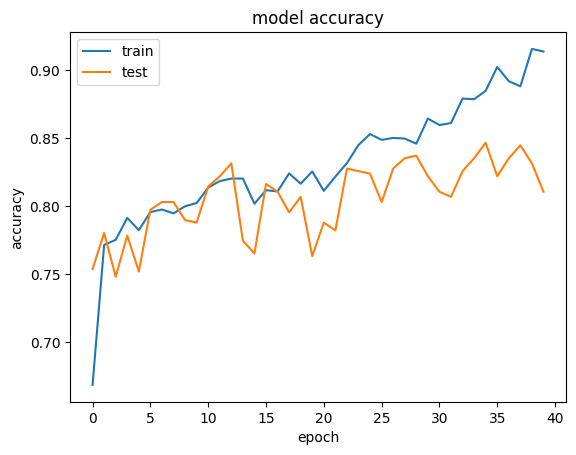

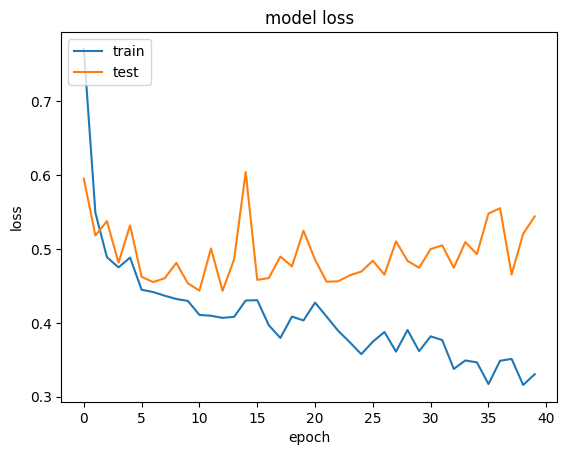

<Figure size 640x480 with 0 Axes>

In [20]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/acc-40.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('images/loss-40.png')

# Predicciones

In [4]:
# cargar modelo
model = load_model('models/cnn_scratch-40.h5')

# cargar imagen
img = Image.open('dataset/data/test/malignant/1.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')


OSError: Unable to synchronously open file (file signature not found)

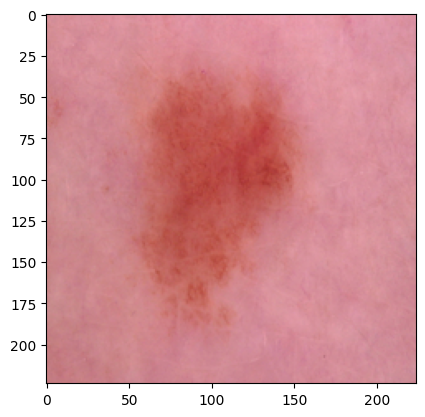

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[[0.9908466  0.00730669]]
Benigno


In [6]:
# cargar modelo
model = load_model('models/cnn_scratch-40.h5')

# cargar imagen
img = Image.open('dataset/data/test/benign/57.jpg')
img = img.resize((224, 224))
img = np.array(img)
img = img/255.
img = img.reshape(1,224,224,3)

# mostrar imagen
plt.imshow(img[0])
plt.show()

# predecir
pred = model.predict(img)
print(pred)
if pred[0][0] > pred[0][1]:
    print('Benigno')
else:
    print('Maligno')
